# Передбачення виживання на «Титаніку»: підготовка даних

Для того, щоб побудувати модель передбачення, нам потрібно спершу перетворити [вхідні дані](https://www.kaggle.com/c/titanic/data) в числову матрицю.

Спробуємо завантажити вхідні CSV-дані в пам’ять, дослідити їх та перетворити належним чином. Для цього ми використаємо популярну бібліотеку для роботи з табличними даними — [pandas](http://pandas.pydata.org/).

In [483]:
# numpy & pandas imports
import numpy as np
import pandas as pd
pd.options.display.max_columns = 100

# plotting libs imports
import matplotlib.pyplot as plt
import seaborn as sns
import pylab as plot
params = { 
    'axes.labelsize': "large",
    'xtick.labelsize': 'x-large',
    'legend.fontsize': 20,
    'figure.dpi': 150,
    'figure.figsize': [25, 7]
}
plot.rcParams.update(params)

Ця директива дозволяє графікам відображатися прямо в записнику, а не в окремому вікні.

In [484]:
%matplotlib inline

In [485]:
# style provisioning to have centered plots :)
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""");

# some plots have deprecated stuff :) stub warnings
import warnings
warnings.filterwarnings('ignore')

## Завантаження даних

Центральним елементом у `pandas` є об’єкт `DataFrame`. Заповнимо його з CSV-файлу:

In [486]:
df_titanic = pd.read_csv("titanic/train.csv")
print(df_titanic.shape)

(891, 12)


In [488]:
df_titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [489]:
df_titanic.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [490]:
# NOTE: the count variable shows that 891 - 714 = 177 values are missing in the Age column.

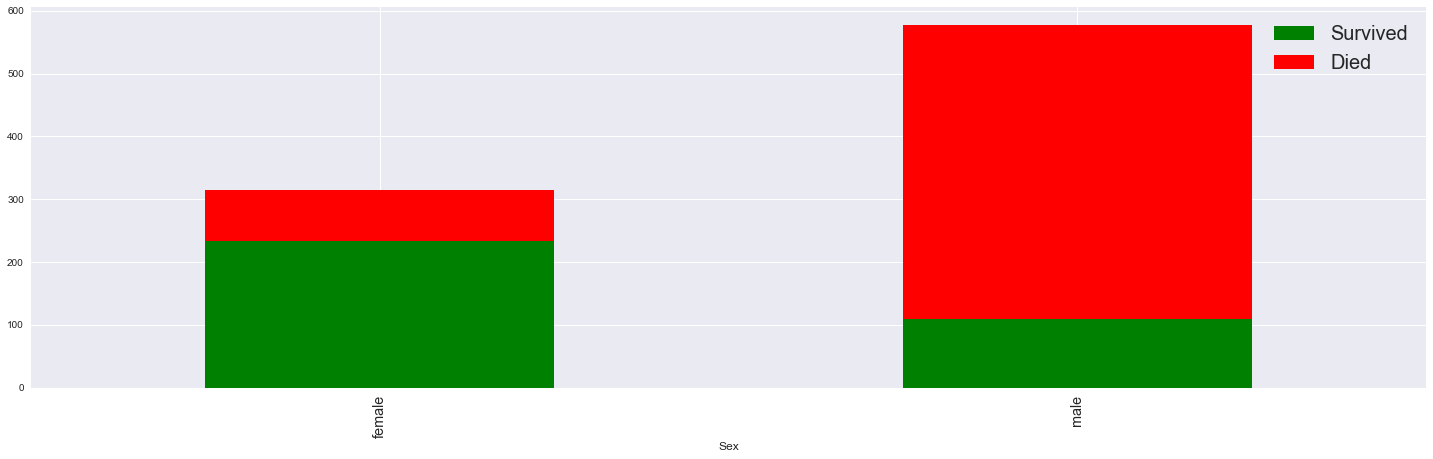

In [491]:
df_titanic['Died'] = 1 - df_titanic['Survived']
df_titanic.groupby('Sex').agg('sum')[['Survived', 'Died']].plot(kind='bar', figsize=(25, 7), stacked=True, colors=['g', 'r']);

In [492]:
# Looks like male passengers are more likely to die -> correlation found: women are more likely to survive

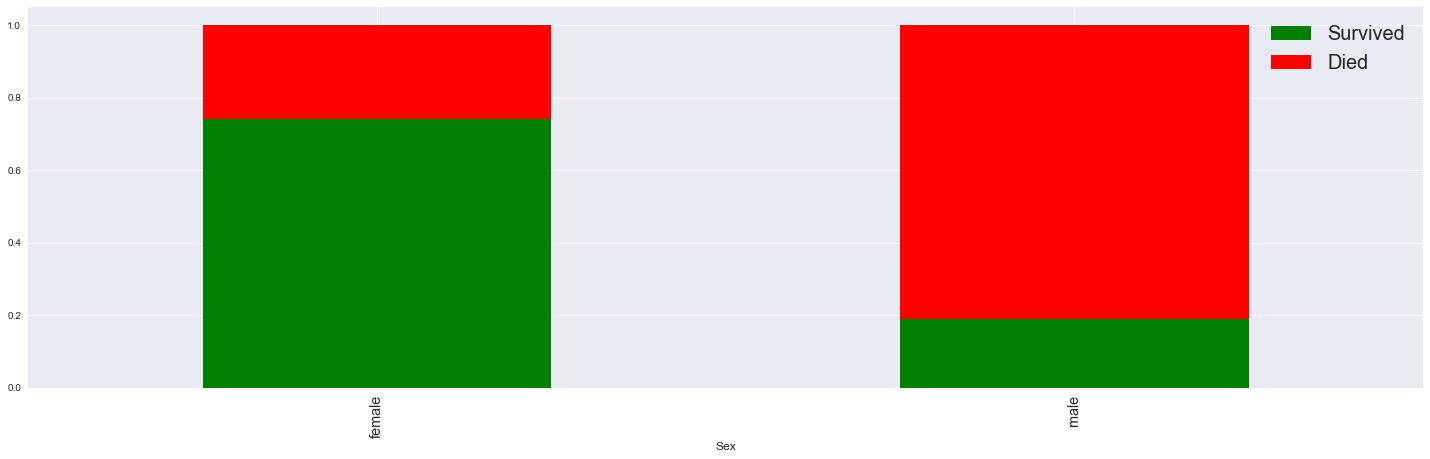

In [493]:
df_titanic.groupby('Sex').agg('mean')[['Survived', 'Died']].plot(kind='bar', figsize=(25, 7), 
                                                           stacked=True, colors=['g', 'r']);

In [494]:
df_titanic.drop(['Died'], inplace=True, axis=1)   # remove redundant feature - won't use it anymore

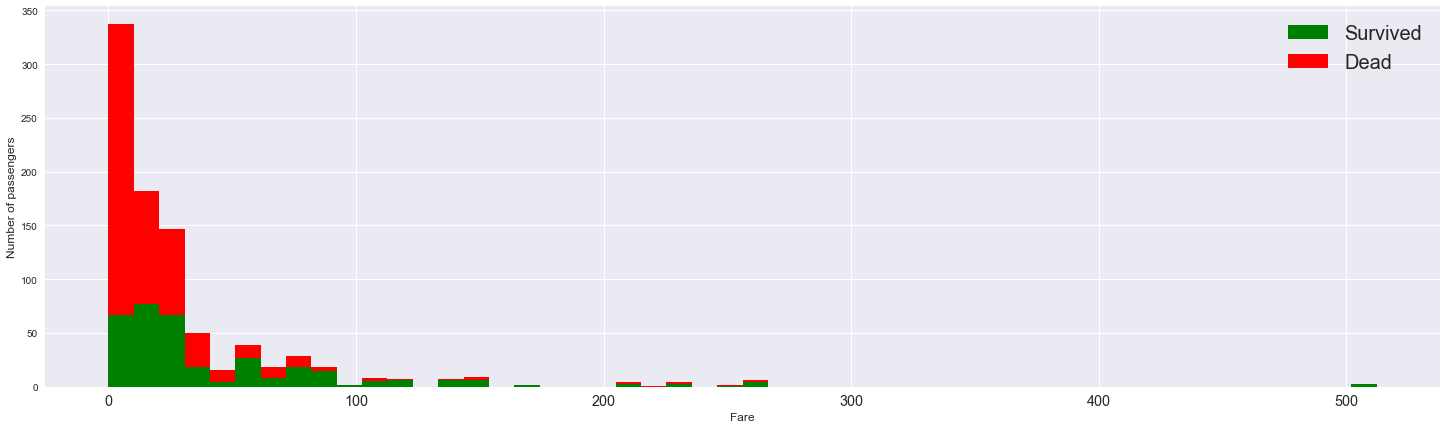

In [495]:
# let's check how ticket fare could impact the survival
figure = plt.figure(figsize=(25, 7))
plt.hist([df_titanic[df_titanic['Survived'] == 1]['Fare'], df_titanic[df_titanic['Survived'] == 0]['Fare']], 
         stacked=True, color = ['g','r'],
         bins = 50, label = ['Survived','Dead'])
plt.xlabel('Fare')
plt.ylabel('Number of passengers')
plt.legend()

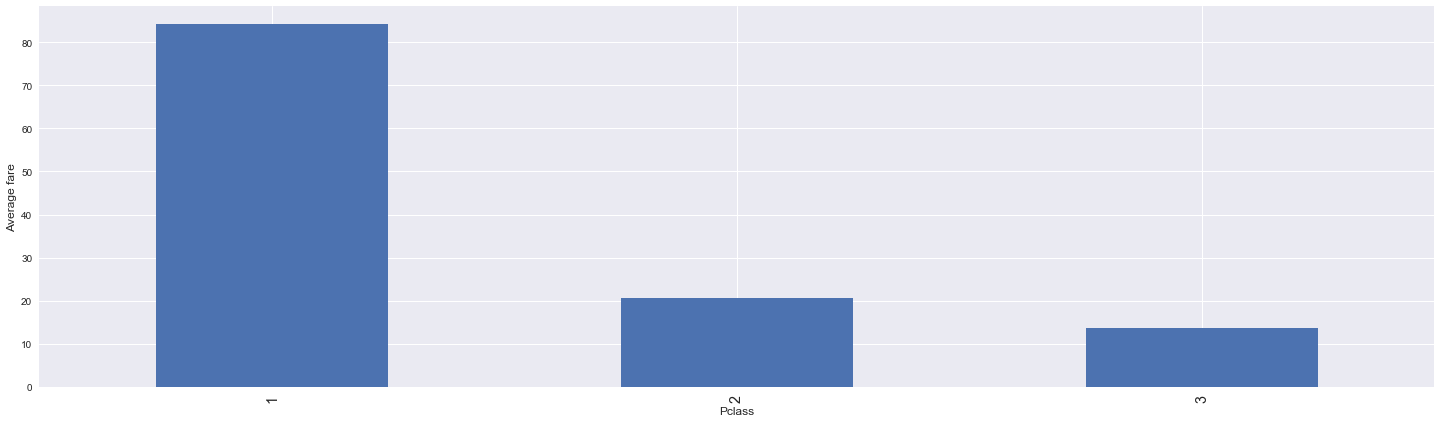

In [496]:
# suppose that ticket fare correlates with the class  
ax = plt.subplot()
ax.set_ylabel('Average fare')
df_titanic.groupby('Pclass').mean()['Fare'].plot(kind='bar', figsize=(25, 7), ax = ax);

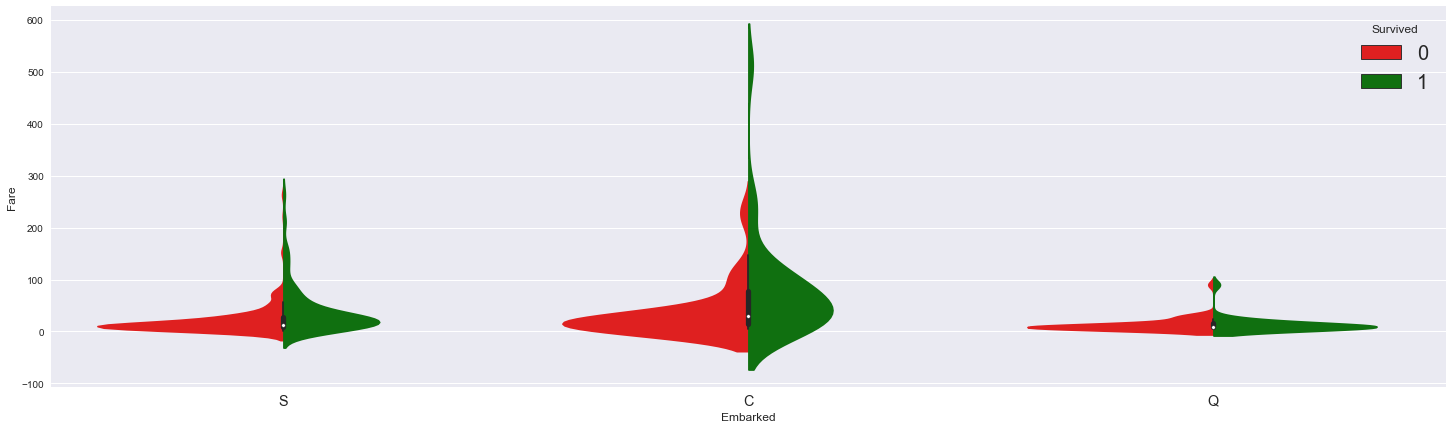

In [497]:
# interesting how the embarkation site affects the survival
fig = plt.figure(figsize=(25, 7))
sns.violinplot(x='Embarked', y='Fare', hue='Survived', data=df_titanic, split=True, palette={0: "r", 1: "g"});

In [498]:
# looks like Embarked C have a lot passengers who pay the highest prices and most probably survived =)

## Обробка категоріальних даних

In [499]:
# helper print utility function
def status(feature):
    print(f'Processing {feature}: ok')

In [500]:
# let's parse all titles from Name feature
titles = set()

for name in df_titanic['Name']:
    titles.add(name.split(',')[1].split('.')[0].strip())

print(titles)

{'Major', 'Lady', 'Mlle', 'the Countess', 'Mrs', 'Capt', 'Rev', 'Dr', 'Sir', 'Col', 'Master', 'Don', 'Mme', 'Ms', 'Jonkheer', 'Miss', 'Mr'}


In [501]:
# let's start our feature engineering :) suppose it'd be better to provide `Title` feature instead `Name`

Title_Dictionary = {
    "Capt": "Officer",
    "Col": "Officer",
    "Major": "Officer",
    "Jonkheer": "Royalty",
    "Don": "Royalty",
    "Sir" : "Royalty",
    "Dr": "Officer",
    "Rev": "Officer",
    "the Countess":"Royalty",
    "Mme": "Mrs",
    "Mlle": "Miss",
    "Ms": "Mrs",
    "Mr" : "Mr",
    "Mrs" : "Mrs",
    "Miss" : "Miss",
    "Master" : "Master",
    "Lady" : "Royalty"
}

def get_titles():
    # we extract the title from each name
    df_titanic['Title'] = df_titanic['Name'].map(lambda name:name.split(',')[1].split('.')[0].strip())
    
    # a map of more aggregated title
    # we map each title
    df_titanic['Title'] = df_titanic.Title.map(Title_Dictionary)
    status('Title')
    return df_titanic

In [502]:
df_titanic = get_titles()

Processing Title: ok


In [503]:
df_titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr


In [504]:
df_titanic[df_titanic['Title'].isnull()]    # check if the titles have been filled correctly.

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title


In [505]:
print(df_titanic.iloc[:891].Age.isnull().sum())     # Number of missing ages in test set

177


In [506]:
# I have assumption that some features have correlation with age. Let's try to group by Sex, Pclass and Title
grouped_train = df_titanic.iloc[:891].groupby(['Sex','Pclass','Title'])
grouped_median_train = grouped_train.median()
grouped_median_train = grouped_median_train.reset_index()[['Sex', 'Pclass', 'Title', 'Age']]
grouped_median_train.head()

,Sex,Pclass,Title,Age
0,female,1,Miss,30.0
1,female,1,Mrs,40.0
2,female,1,Officer,49.0
3,female,1,Royalty,40.5
4,female,2,Miss,24.0


In [507]:
# let's create a function that fills in the missing age based on these different attributes
def fill_age(row):
    condition = (
        (grouped_median_train['Sex'] == row['Sex']) & 
        (grouped_median_train['Title'] == row['Title']) & 
        (grouped_median_train['Pclass'] == row['Pclass'])
    ) 
    return grouped_median_train[condition]['Age'].values[0]


def process_age():
    # a function that fills the missing values of the Age variable
    df_titanic['Age'] = df_titanic.apply(lambda row: fill_age(row) if np.isnan(row['Age']) else row['Age'], axis=1)
    status('age')
    return df_titanic


df_titanic = process_age()

Processing age: ok


In [509]:
print(df_titanic.iloc[:891].Age.isnull().sum())     # Number of missing ages in dataframe

0


In [510]:
# drops the Name column since we won't be using it anymore because we created a Title column
def process_names(df_titanic):
    # cleaning the Name variable
    df_titanic.drop('Name', axis=1, inplace=True)
    
    # encoding in dummy variable
    titles_dummies = pd.get_dummies(df_titanic['Title'], prefix='Title')
    df_titanic = pd.concat([df_titanic, titles_dummies], axis=1)
    
    # removing the title variable
    df_titanic.drop('Title', axis=1, inplace=True)
    
    status('names')
    return df_titanic


df_titanic = process_names(df_titanic)

Processing names: ok


In [511]:
df_titanic.head()    #  encode the title values using a dummy encoding

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty
0,1,0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,0,1,0,0,0
1,2,1,1,female,38.0,1,0,PC 17599,71.2833,C85,C,0,0,0,1,0,0
2,3,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,1,0,0,0,0
3,4,1,1,female,35.0,1,0,113803,53.1000,C123,S,0,0,0,1,0,0
4,5,0,3,male,35.0,0,0,373450,8.0500,NaN,S,0,0,1,0,0,0


In [512]:
print(df_titanic.iloc[:891].Embarked.isnull().sum())     # Number of missing Embarked in dataframe

2


In [514]:
def process_embarked(df_titanic):
    # two missing embarked values - filling them with the most frequent one in the train set(S)
    df_titanic.Embarked.fillna('S', inplace=True)
    # dummy encoding -> let's replace one Embarked feature with new 3 binary features (that have value 0 or 1)
    embarked_dummies = pd.get_dummies(df_titanic['Embarked'], prefix='Embarked')
    df_titanic = pd.concat([df_titanic, embarked_dummies], axis=1)
    df_titanic.drop('Embarked', axis=1, inplace=True)
    status('embarked')
    return df_titanic


df_titanic = process_embarked(df_titanic)

Processing embarked: ok


In [515]:
df_titanic.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty,Embarked_C,Embarked_Q,Embarked_S
0,1,0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,0,0,1,0,0,0,0,0,1
1,2,1,1,female,38.0,1,0,PC 17599,71.2833,C85,0,0,0,1,0,0,1,0,0
2,3,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,0,1,0,0,0,0,0,0,1
3,4,1,1,female,35.0,1,0,113803,53.1000,C123,0,0,0,1,0,0,0,0,1
4,5,0,3,male,35.0,0,0,373450,8.0500,NaN,0,0,1,0,0,0,0,0,1


In [516]:
# looks like cabin can be groupped by first letter (in Nan value -> replace missing cabins with U (for Uknown))
cabins = set()

for c in df_titanic.iloc[:891]['Cabin']:
    try:
        cabins.add(c[0])
    except:
        cabins.add('U')

In [517]:
print(sorted(cabins))

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', 'U']


In [518]:
def process_cabin(df_titanic):
    # replacing missing cabins with U (for Uknown)
    df_titanic.Cabin.fillna('U', inplace=True)
    
    # mapping each Cabin value with the cabin letter
    df_titanic['Cabin'] = df_titanic['Cabin'].map(lambda c: c[0])
    
    # dummy encoding ...
    cabin_dummies = pd.get_dummies(df_titanic['Cabin'], prefix='Cabin')    
    df_titanic = pd.concat([df_titanic, cabin_dummies], axis=1)

    df_titanic.drop('Cabin', axis=1, inplace=True)
    status('cabin')
    return df_titanic


df_titanic = process_cabin(df_titanic)

Processing cabin: ok


In [520]:
df_titanic.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty,Embarked_C,Embarked_Q,Embarked_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_U
0,1,0,3,male,22.0,1,0,A/5 21171,7.2500,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
1,2,1,1,female,38.0,1,0,PC 17599,71.2833,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0
2,3,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
3,4,1,1,female,35.0,1,0,113803,53.1000,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0
4,5,0,3,male,35.0,0,0,373450,8.0500,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1


In [521]:
def process_sex():
    # mapping string values to numerical one 
    df_titanic['Sex'] = df_titanic['Sex'].map({'male': 1, 'female': 0})
    status('Sex')
    return df_titanic


df_titanic = process_sex()

Processing Sex: ok


In [522]:
df_titanic.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty,Embarked_C,Embarked_Q,Embarked_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_U
0,1,0,3,1,22.0,1,0,A/5 21171,7.2500,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
1,2,1,1,0,38.0,1,0,PC 17599,71.2833,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0
2,3,1,3,0,26.0,0,0,STON/O2. 3101282,7.9250,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
3,4,1,1,0,35.0,1,0,113803,53.1000,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0
4,5,0,3,1,35.0,0,0,373450,8.0500,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1


In [523]:
def process_pclass(df_titanic):
    # encoding into 3 categories:
    pclass_dummies = pd.get_dummies(df_titanic['Pclass'], prefix="Pclass")
    
    # adding dummy variable
    df_titanic = pd.concat([df_titanic, pclass_dummies],axis=1)
    
    # removing "Pclass"
    df_titanic.drop('Pclass',axis=1,inplace=True)
    
    status('Pclass')
    return df_titanic


df_titanic = process_pclass(df_titanic)

Processing Pclass: ok


In [524]:
df_titanic.head()

,PassengerId,Survived,Sex,Age,SibSp,Parch,Ticket,Fare,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty,Embarked_C,Embarked_Q,Embarked_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_U,Pclass_1,Pclass_2,Pclass_3
0,1,0,1,22.0,1,0,A/5 21171,7.2500,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1
1,2,1,0,38.0,1,0,PC 17599,71.2833,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0
2,3,1,0,26.0,0,0,STON/O2. 3101282,7.9250,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1
3,4,1,0,35.0,1,0,113803,53.1000,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0
4,5,0,1,35.0,0,0,373450,8.0500,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1


In [525]:
def process_family():
    # introducing a new feature : the size of families (including the passenger)
    df_titanic['FamilySize'] = df_titanic['Parch'] + df_titanic['SibSp'] + 1
    
    # introducing other features based on the family size
    df_titanic['Singleton'] = df_titanic['FamilySize'].map(lambda s: 1 if s == 1 else 0)
    df_titanic['SmallFamily'] = df_titanic['FamilySize'].map(lambda s: 1 if 2 <= s <= 4 else 0)
    df_titanic['LargeFamily'] = df_titanic['FamilySize'].map(lambda s: 1 if 5 <= s else 0)
    
    status('family')
    return df_titanic


df_titanic = process_family()

Processing family: ok


In [526]:
df_titanic.head()

,PassengerId,Survived,Sex,Age,SibSp,Parch,Ticket,Fare,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty,Embarked_C,Embarked_Q,Embarked_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_U,Pclass_1,Pclass_2,Pclass_3,FamilySize,Singleton,SmallFamily,LargeFamily
0,1,0,1,22.0,1,0,A/5 21171,7.2500,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,2,0,1,0
1,2,1,0,38.0,1,0,PC 17599,71.2833,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,2,0,1,0
2,3,1,0,26.0,0,0,STON/O2. 3101282,7.9250,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,1,1,0,0
3,4,1,0,35.0,1,0,113803,53.1000,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,2,0,1,0
4,5,0,1,35.0,0,0,373450,8.0500,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,1,1,0,0


In [527]:
print(df_titanic.shape)

(891, 33)


In [ ]:
# second value in tuple is out amount of new features - looks like it is too big =)
# lets remove redundant/useless features

In [528]:
# also remove features: 'PassengerID', 'Ticket', 'index' since these are not informative features
df_titanic.reset_index(inplace=True)
df_titanic.drop(['index', 'PassengerId', 'Ticket'], inplace=True, axis=1)

# extracting and then removing the targets from the training data 
targets = df_titanic.Survived
train = df_titanic
train.drop(['Survived'], 1, inplace=True)

In [529]:
train.head()

,Sex,Age,SibSp,Parch,Fare,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty,Embarked_C,Embarked_Q,Embarked_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_U,Pclass_1,Pclass_2,Pclass_3,FamilySize,Singleton,SmallFamily,LargeFamily
0,1,22.0,1,0,7.2500,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,2,0,1,0
1,0,38.0,1,0,71.2833,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,2,0,1,0
2,0,26.0,0,0,7.9250,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,1,1,0,0
3,0,35.0,1,0,53.1000,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,2,0,1,0
4,1,35.0,0,0,8.0500,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,1,1,0,0


In [530]:
targets.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

In [531]:
train.shape

(891, 30)

In [ ]:
# looks like amount of features is less than before, but it's still quite large
# I suggest to use Random Forest Classifier with big amount of estimators to filter out the most important features
# and select the "right" number of features that capture the essential
# I'll be using Random Forests, because I've heard that they have proven a great efficiency in Kaggle competitions =)
# and also I've heard that it's very efficient ensemble method =)
# Tree-based estimators can be used to compute feature importances,
# which in turn can be used to discard irrelevant features.

In [532]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

clf = RandomForestClassifier(n_estimators=50, max_features='sqrt')
clf = clf.fit(train, targets)

features = pd.DataFrame()
features['feature'] = train.columns
features['importance'] = clf.feature_importances_
features.sort_values(by=['importance'], ascending=True, inplace=True)
features.set_index('feature', inplace=True)

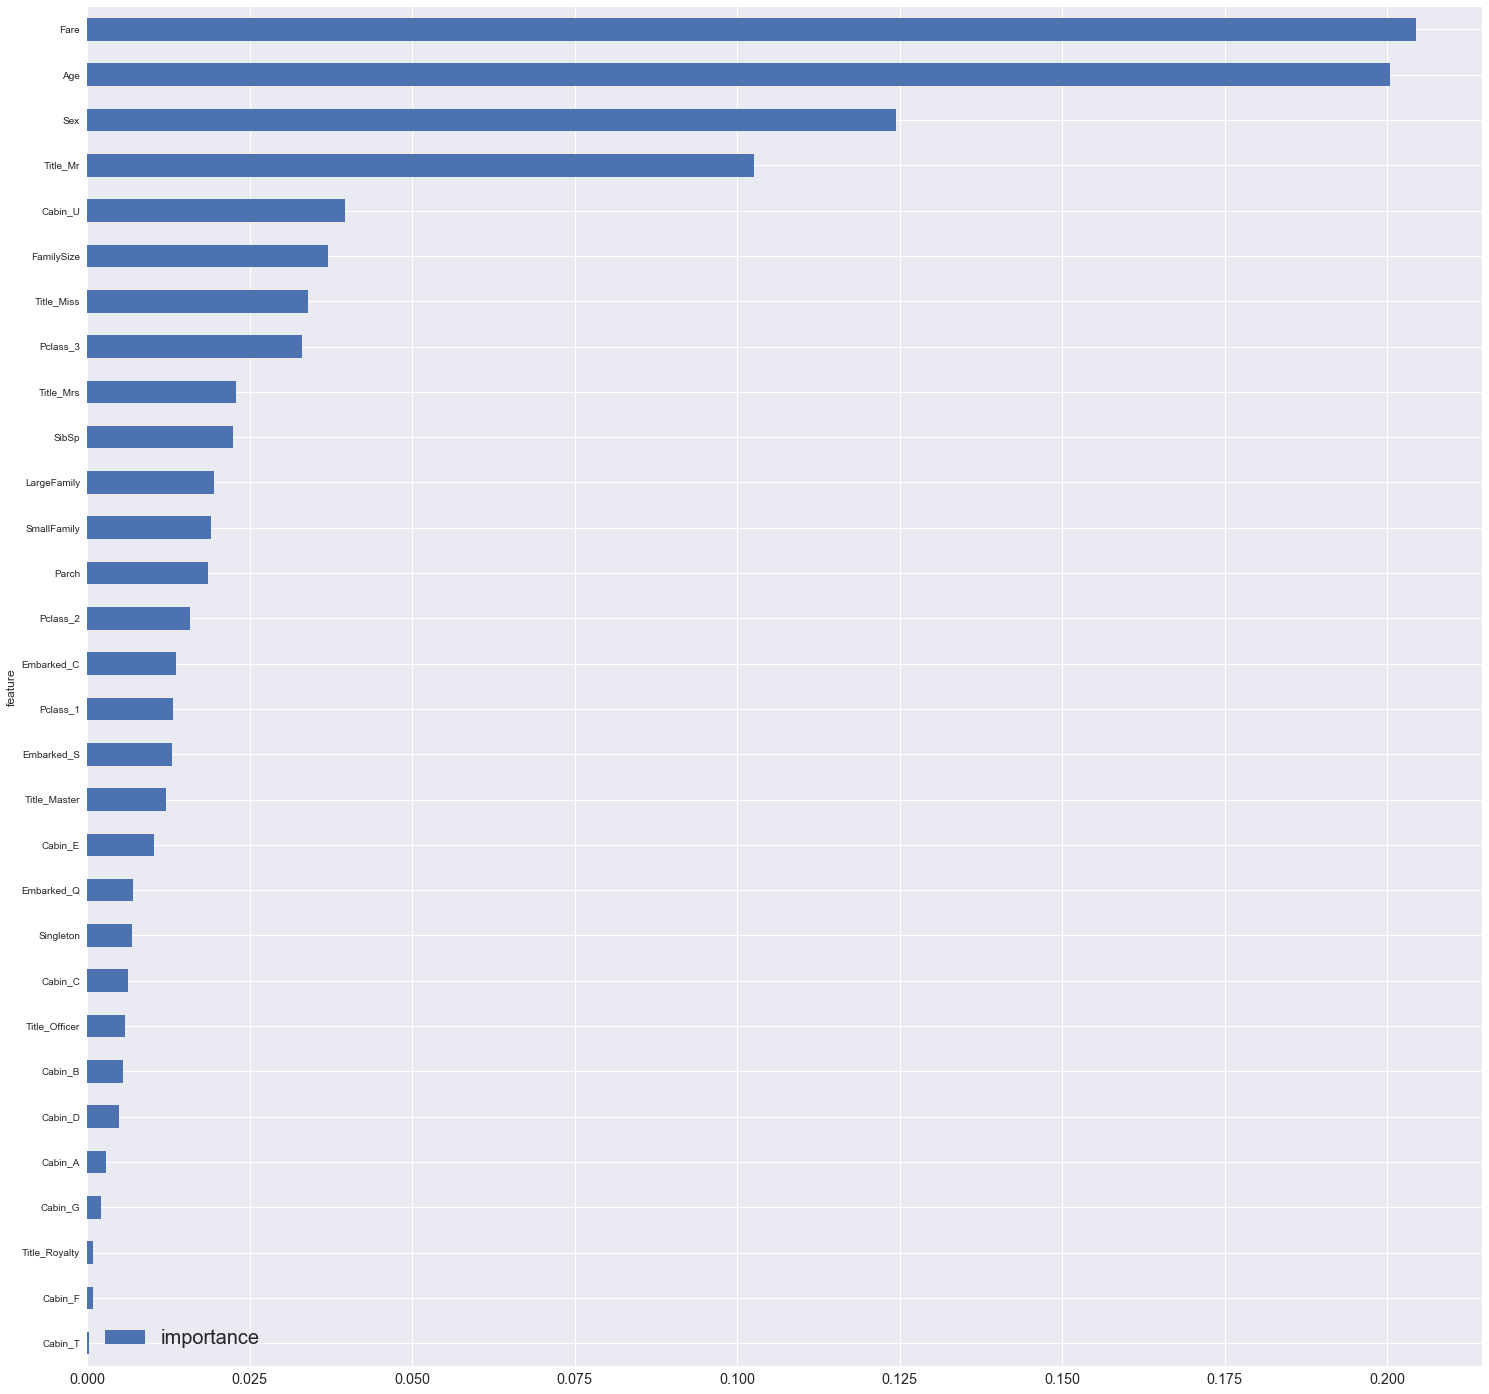

In [533]:
features.plot(kind='barh', figsize=(25, 25))

In [534]:
# let's now transform our train data in a more compact dataset
model = SelectFromModel(clf, prefit=True)
train_reduced = model.transform(train)
print(train_reduced.shape)

(891, 7)


In [536]:
# Let's try different base models
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV


logreg = LogisticRegression()
logreg_cv = LogisticRegressionCV()
rf = RandomForestClassifier()
gboost = GradientBoostingClassifier()

models = [logreg, logreg_cv, rf, gboost]

# to evaluate our model I'll be using a 5-fold cross validation with the accuracy 
# I'll define a small scoring function.
def compute_score(clf, X, y, scoring='accuracy'):
    xval = cross_val_score(clf, X, y, cv = 5, scoring=scoring)
    return np.mean(xval)

In [537]:
for model in models:
    print('Cross-validation of : {0}'.format(model.__class__))
    score = compute_score(clf=model, X=train_reduced, y=targets, scoring='accuracy')
    print('CV score = {0}'.format(score))
    print('****')

Cross-validation of : <class 'sklearn.linear_model.logistic.LogisticRegression'>
CV score = 0.8103235102509515
****
Cross-validation of : <class 'sklearn.linear_model.logistic.LogisticRegressionCV'>
CV score = 0.8182078646365841
****
Cross-validation of : <class 'sklearn.ensemble.forest.RandomForestClassifier'>
CV score = 0.8058415405135211
****
Cross-validation of : <class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>
CV score = 0.8226705066730219
****


In [539]:
### Get following Accuracy rate:
# 81% within LogisticRegressions (LogisticRegression and LogisticRegressionCV) with
# 80% within RandomForestClassifier
# 82% within GradientBoostingClassifier

In [542]:
# just saving train and target datasets
pd.DataFrame(train_reduced).to_csv("titanic/train_X.csv", header=True, index=False)
targets.to_csv("titanic/train_y.csv", header=True, index=False)